# CSCI 381 Term Project
### *Seena Thomas and Claire Wagner*

### Introduction

As advances continue in medical research and technology, patient data can be used to better identify medical conditions in order to assist both patients and the healthcare industry. In light of the increasing demand for reliable resources to support the large influx of patient data, there is a greater need than ever for understanding and developing proper methods to analyze and interpret that data. 

Our goal in this project is to use machine learning techniques to develop an automated tool to facilitate the diagnosis of early stage diabetes by predicting the presence or absence of diabetes based on patient questionnaires (a binary classification problem). A medical practitioner could then use the prediction to inform their diagnosis in order to provide a personalized and effective treatment plan for their patient. This machine learning tool would not replace medical practitioners' expertise; rather, it would serve as a resource during the initial screening process to help practitioners provide personalized and effective treatment plans for their patients.

### Set Up

Firstly, we will import all libraries and library functions that we will be using. We will also read in our dataset and split it into observations (X) and targets (y). Finally, we will define the constants and helper functions that we will be using throughout our experiments. (Note: `matplotlib` must be at least version 3.5.0 to successfully run all cells in this document, and the dataset `early_stage_diabetes.csv` should be located in the same folder as this document.)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

df = pd.read_csv("early_stage_diabetes.csv")
X = df.drop(columns=['class'])
y = df['class']

# random state to use by default
const_random_state = 42

# define indices for metrics in arrays of results returned by experiments
metric_indices = {"sensitivity": 0, "accuracy": 1}

# helper function to generate a list of components in increasing order for use in PCA
# (from 1 to D, inclusive, where D is the dimensionality of the dataset)
def components_arange(X):
    return np.arange(1, X.shape[1]+1)

# helper function for computing sensitivity and accuracy
def get_metrics(model, dataset, targets):
    n = dataset.shape[0]
    tp = sum((model.predict(dataset) == True) & (targets == True))
    tn = sum((model.predict(dataset) == False) & (targets == False))
    fp = sum((model.predict(dataset) == True) & (targets == False))
    fn = sum((model.predict(dataset) == False) & (targets == True))
    assert(tp + tn + fp + fn == n)
    accuracy = (tp+tn)/n
    sensitivity = tp/(tp+fn) # also known as recall
    return [sensitivity, accuracy]

# helper function for plotting metrics
def plot_metrics(x, y_array, titles, x_label, y_label=None, x_major_grid=True, y_major_grid=True, metric_dict=metric_indices, separate_plots=False, figsize=(10, 7), legend_loc="best", xscale=None, ticks=None):
    ncols = len(y_array)
    nrows = len(metric_dict) if separate_plots else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
    if xscale is not None:
        if ncols > 1:
            for ax in axes.flat:
                ax.set_xscale(xscale)
        else:
            axes.set_xscale(xscale)
    for j in range(ncols):
        i = 0
        for metric, index in metric_dict.items():
            if nrows > 1 and ncols > 1:
                axis = axes[i][j]
            elif nrows == 1 and ncols == 1:
                axis = axes
            elif nrows == 1:
                axis = axes[j]
            elif ncols == 1:
                axis = axes[i]
            axis.plot(x, y_array[j][:, index], label=metric)
            if x_major_grid:
                axis.xaxis.grid(True, which='major')
            if y_major_grid:
                axis.yaxis.grid(True, which='major')
            axis.tick_params(left=True, labelleft=True)
            axis.legend(loc=legend_loc)
            i+=1
        if nrows > 1 and ncols > 1:
            first_axis = axes[0][j]
            last_axis = axes[-1][j]
        elif nrows == 1 and ncols == 1:
            first_axis = last_axis = axes
        elif nrows == 1:
            first_axis = last_axis = axes[j]
        elif ncols == 1:
            first_axis = axes[0]
            last_axis = axes[-1]
        first_axis.set_title(titles[j])
        last_axis.set_xlabel(x_label)
        if y_label:
            first_axis.set_ylabel(y_label)
        if ticks is not None:
            if 'x_major' in ticks:
                first_axis.xaxis.set_major_locator(ticker.MultipleLocator(ticks['x_major']))
            if 'x_minor' in ticks:
                first_axis.xaxis.set_minor_locator(ticker.MultipleLocator(ticks['x_minor']))
            if 'y_major' in ticks:
                first_axis.yaxis.set_major_locator(ticker.MultipleLocator(ticks['y_major']))
            if 'y_minor' in ticks:
                first_axis.yaxis.set_minor_locator(ticker.MultipleLocator(ticks['y_minor']))
    return (fig, axes)

### Dataset

Our data source is the <a href='https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.'>Early Stage Diabetes Risk Prediction Dataset</a> provided by M. M. Faniqul Islam et al., which was donated to UCI in July 2020. This dataset contains patients' responses to questionnaires regarding their age, gender, and various diabetes-related signs and symptoms at Sylhet Diabetes Hospital in Sylhet, Bangladesh. Each observation is associated with a physician's classification of that patient as positive or negative for diabetes, which is recorded in the feature `class`.

The dataset contains 520 observations, each with 17 features. There are no missing values. The target attribute, `class`, has a balance of about 61.5% positive to 38.5% negative diagnoses. We cleaned up the dataset by converting all non-numeric data to integers (encoding male gender, presence of a symptom, and positive diagnoses as 1 while encoding female gender, absence of a symptom, and negative diagnoses as 0). All features except for `age` are binary, as shown in the graph below.

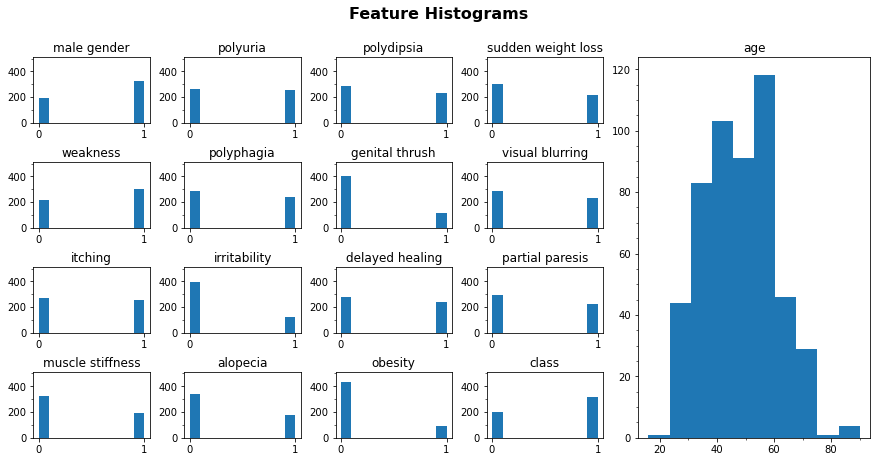

In [2]:
fig, axes = plt.subplot_mosaic(
    mosaic=np.hstack((df.columns.drop('age').to_numpy().reshape((4,4)), np.full((4,1),'age'))),
    figsize=(15,7),
    gridspec_kw=dict(width_ratios=(1/6, 1/6, 1/6, 1/6, 1/3))
)
for col in df.columns:
    axes[col].hist(df[col])
    axes[col].set_title(col, size=12)
    if col != 'age':
        axes[col].set_ylim(0, 510)
        axes[col].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[col].yaxis.set_major_locator(ticker.MultipleLocator(200))
        axes[col].yaxis.set_minor_locator(ticker.MultipleLocator(100))
axes['age'].xaxis.set_minor_locator(ticker.MultipleLocator(10))
axes['age'].yaxis.set_minor_locator(ticker.MultipleLocator(5))
fig.suptitle("Feature Histograms", size=16, weight='semibold')
plt.subplots_adjust(hspace=0.6, wspace=0.25)

### Model Training

To observe and analyze the performance of various machine learning techniques on our binary classification problem, we have experimented with varying hyperparameters and degrees of principal component analysis.

For the sake of consistency and comparability, wherever some form of user-specified random state is required, we use a constant integer seed, which allows us to reproduce results across executions. For example, we use the same random seed throughout all of our experiments when splitting the dataset into a training set and test set, which ensures that all models are trained and tested on the same data. Additionally, we use the `stratify` option to preserve the positive-negative target ratio of the original dataset in both the training set and the test set.

### Model Evaluation

Since our goal is to provide a machine learning tool to assist with screening for early stage diabetes, a high rate of false negatives is more problematic than a high rate of false positives. It would be better for a medical practitioner to take a unnecessary second look at the case of a patient who, though negative for diabetes, is misdiagnosed by the model as positive than for that practitioner to neglect to take a closer look at a patient who, though positive for diabetes, is misdiagnosed by the model as negative.

Given the potentially grave consequences of false negatives, therefore, we consider not only accuracy but also sensitivity when evaluating the performance of models. Accuracy is defined as the number of correct predictions divided by the total number of observations, while sensitivity (also known as recall or the true positive rate) is defined as the number of true positives divided by the total number of positive predictions.

$$ Accuracy = {{TP + TN} \over N} $$

$$ Sensitivity = {TP \over {TP + FN}} $$

As sensitivity increases, the rate of false negatives decreases. With high rates of sensitivity, therefore, we can have confidence that our model will reliably diagnose patients who are truly positive for diabetes.

### K Nearest Neighbors

First, we will examine the performance of K Nearest Neighbors (KNN) on our binary classification task. In our first experiment, we trained and tested a KNN model with k nearest neighbors where k ranged from 1 to 10 to see how varying the numbers of neighbors affects the performance of the model.

In [3]:
def knn_experiment(X, y, k_array, random_state=const_random_state):
    test_metrics = []
    train_metrics = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
    for k in k_array:
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        test_metrics.append(get_metrics(model, X_test, y_test))
        train_metrics.append(get_metrics(model, X_train, y_train))
    return (np.array(test_metrics), np.array(train_metrics))

k_array = np.arange(1,11)
(knn_test_metrics, knn_train_metrics) = knn_experiment(X, y, k_array)

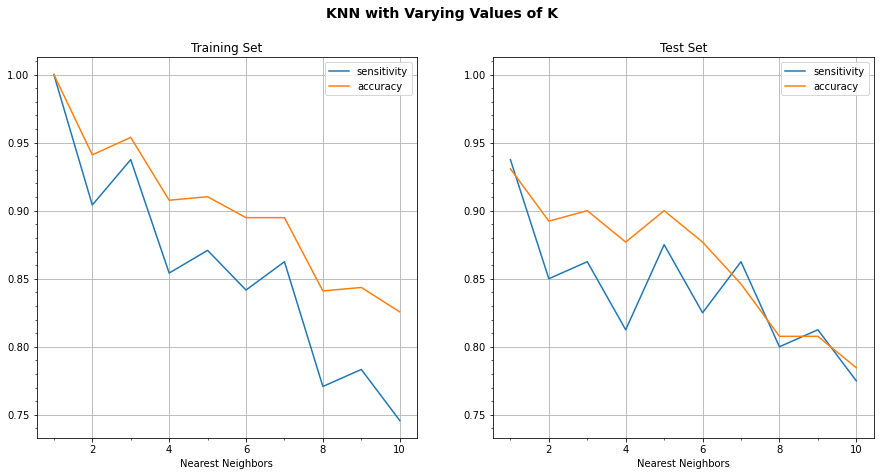

In [4]:
(fig, axes) = plot_metrics(x = k_array, y_array = [knn_train_metrics, knn_test_metrics],
             titles = ["Training Set", "Test Set"],
             ticks = {'x_minor': 1, 'y_minor': 0.01},
             x_label = "Nearest Neighbors", figsize=(15,7))
fig.suptitle("KNN with Varying Values of K", size=14, weight='semibold')
print()

In this experiment, the best performance on both training and test sets was achieved with k = 1, and the second-best performance on the test set was achieved with k = 5. With k = 1, the model displays overfitting (since the nearest neighbor to each observation in the training set is itself) but still achieves the best performance on the test set. Both sensitivity and accuracy generally decrease as the number of neighbors increases. There may be overfitting since the training set results are typically higher than the test set results.

Additionally, even numbers of neighbors lead to worse performance than odd numbers of neighbors, which may be explained by the fact that sklearn's KNN algorithm breaks ties by simply choosing the first candidate class (https://stats.stackexchange.com/a/144734).

It is possible that KNN achieves the best performance with a small number of neighbors because of the curse of dimensionality. To examine this hypothesis, we performed an experiment with KNN using PCA. We used only odd values of k, ranging from 1 to 9, since the previous experiment showed a decrease in performance with even numbers of neighbors.

For each value of k, we tested the performance of KNN combined with PCA with c components, where c ranges from 1 to 16 (the dimensionality of the dataset). This allowed us to see whether reducing the dimensionality of the data improves the performance of KNN.

In [5]:
def knn_with_neighbors_and_pca_experiment(X, y, k_array, random_state=const_random_state):
    test_metrics = []
    train_metrics = []
    for k in k_array:
        kth_test_metrics = []
        kth_train_metrics = []
        for M in components_arange(X):
            X_pca = PCA(n_components=M).fit_transform(X)
            X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, stratify=y, random_state=random_state)
            model = KNeighborsClassifier(n_neighbors=k).fit(X_train_pca, y_train)
            kth_test_metrics.append(get_metrics(model, X_test_pca, y_test))
            kth_train_metrics.append(get_metrics(model, X_train_pca, y_train))
        test_metrics.append(kth_test_metrics)
        train_metrics.append(kth_train_metrics)
    return (np.array(test_metrics), np.array(train_metrics))

odd_k_array = np.arange(1,11,2) # odd numbers of neighbors from 1 to 9
(knn_neighbors_pca_test_metrics, knn_neighbors_pca_train_metrics) = knn_with_neighbors_and_pca_experiment(X, y, odd_k_array)

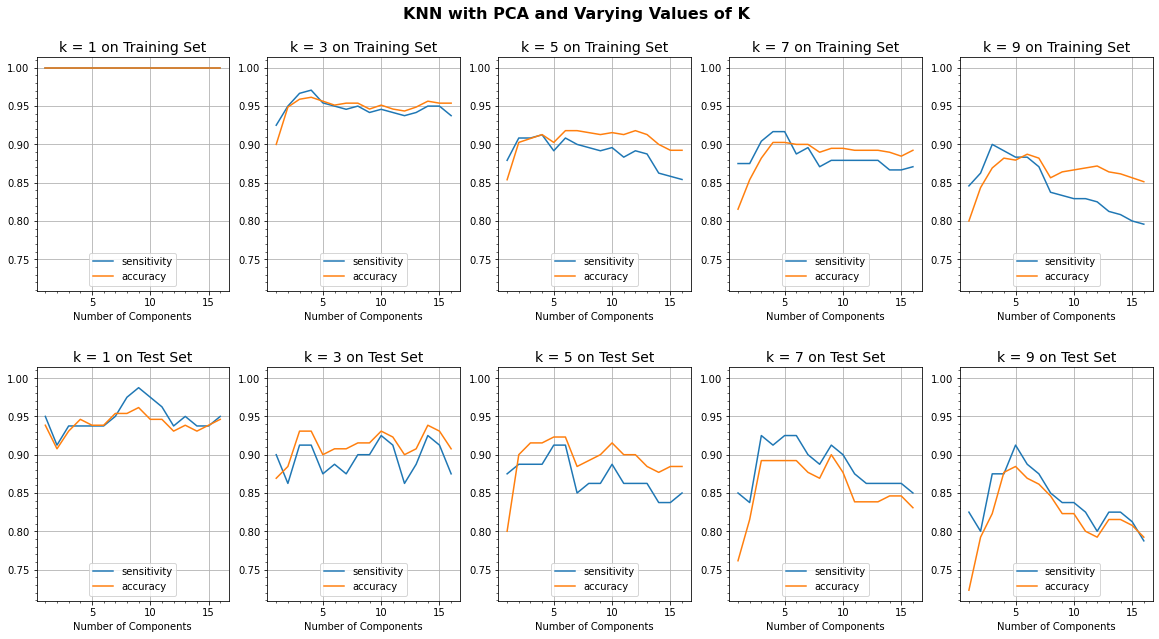

In [6]:
components = components_arange(X)
experiment_results = (knn_neighbors_pca_train_metrics, knn_neighbors_pca_test_metrics)
experiment_result_labels = ("Training Set", "Test Set")

fig, axes = plt.subplots(figsize=(20,10), nrows=len(experiment_results), ncols=odd_k_array.size, sharex=True, sharey=True)
fig.suptitle('KNN with PCA and Varying Values of K', y=0.95, size=16, weight='semibold')
axes[0][0].xaxis.set_minor_locator(ticker.MultipleLocator(1)) # copied to all other axes since sharex is True
axes[0][0].yaxis.set_minor_locator(ticker.MultipleLocator(0.01)) # copied to all other axes since sharey is True
for j, k in enumerate(odd_k_array):
    #axes[-1][j].set_xlabel('Number of Components')
    for i in range(len(experiment_results)):
        for metric, index in metric_indices.items():
            axes[i][j].plot(components, experiment_results[i][j][:, index], label=metric)
        axes[i][j].set_title('k = ' + str(k) + ' on ' + experiment_result_labels[i], size=14)
        axes[i][j].legend(loc='lower center')
        axes[i][j].tick_params(left=True, labelleft=True, labelbottom=True)
        axes[i][j].set_xlabel('Number of Components')
        axes[i][j].xaxis.grid(True, which='major')
        axes[i][j].yaxis.grid(True, which='major')
plt.subplots_adjust(hspace=0.33)

PCA does seem to alleviate the curse of dimensionality for KNN because the experiment results show generally worse performance with full dimensionality (16 components) than with lower dimensionality (<15 components). The best number of components changes depending on the value of k, but it is never 1 or 16, suggesting that moderate reductions in dimensionality achieve the best results.

As in the previous experiment, sensitivity and accuracy both continue to decrease as the number of neighbors increases. The training set results and test set results are consistent with one another for each value of k, although there may be overfitting since the training set results are still typically higher than the test set results.

### Gaussian Mixture Models

Next, we designed an experiment to see how PCA affects the performance of a Gaussian mixture model (GMM). We specified 2 model components (positive and negative diagnoses) for the mixture model. We ran the experiment with PCA using c components where c ranged from 1 to 16 as before. For each value of c, the GMM was trained and tested 10 times, and the average was used as the final result for that value of c.

Noticing that the results of this experiment varied considerably from run to run, we ran the experiment three times so that we could compare the results.

In [7]:
# num_trials is number of trials to run for each component (the average results of these trials will be used)
def gaussians_with_pca_experiment(X, y, num_model_components, num_trials=10, random_state=const_random_state):
    test_metrics = [] # average of num_trials trials with M components is stored in index M-1
    train_metrics = [] # average of num_trials trials with M components is stored in index M-1
    for M in components_arange(X):
        test_results = []
        train_results = []
        for i in range(num_trials):
            X_pca = PCA(n_components=M).fit_transform(X)
            X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, stratify=y, random_state=random_state)
            model = GaussianMixture(num_model_components).fit(X_train_pca, y_train)
            test_results.append(get_metrics(model, X_test_pca, y_test))
            train_results.append(get_metrics(model, X_train_pca, y_train))
        test_metrics.append(np.mean(test_results, axis=0))
        train_metrics.append(np.mean(train_results, axis=0))
    return (np.array(test_metrics), np.array(train_metrics))

ntrials = 3
runs_per_trial = 10
all_gauss_pca_test_metrics = []
all_gauss_pca_train_metrics = []
for i in range(ntrials):
    (ith_gauss_pca_test_metrics, ith_gauss_pca_train_metrics) = gaussians_with_pca_experiment(X, y, 2, runs_per_trial)
    all_gauss_pca_test_metrics.append(ith_gauss_pca_test_metrics)
    all_gauss_pca_train_metrics.append(ith_gauss_pca_train_metrics)

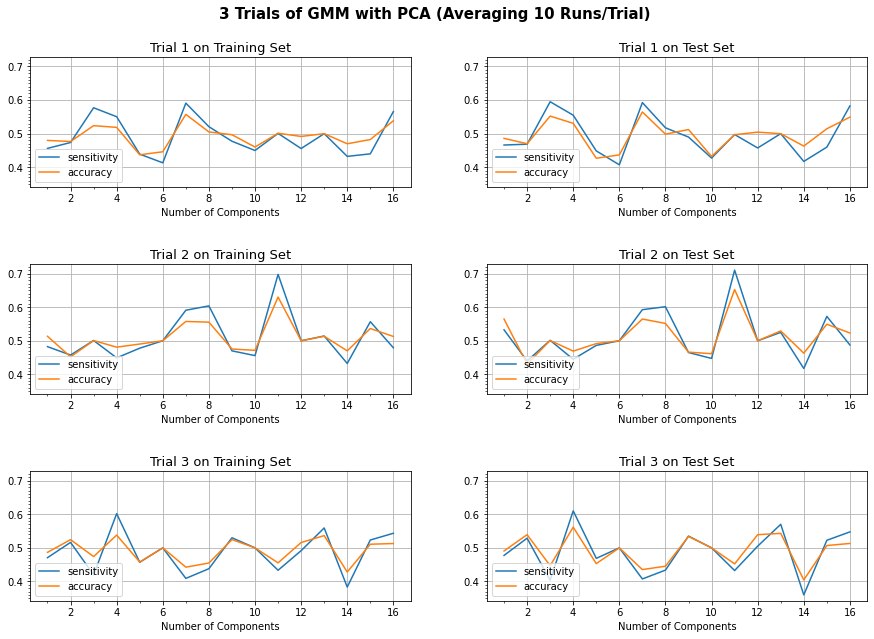

In [8]:
experiment_results = (all_gauss_pca_train_metrics, all_gauss_pca_test_metrics)
experiment_result_labels = ("Training Set", "Test Set")
components = components_arange(X)

fig, axes = plt.subplots(nrows=ntrials, ncols=len(experiment_results), sharex=True, sharey=True, figsize=(15,10))
fig.suptitle(str(ntrials) + ' Trials of GMM with PCA (Averaging ' + str(runs_per_trial) +' Runs/Trial)', y=0.95, size=15, weight='semibold')
axes[0][0].xaxis.set_minor_locator(ticker.MultipleLocator(1)) # copied to all other axes since sharex is True
axes[0][0].yaxis.set_minor_locator(ticker.MultipleLocator(0.01)) # copied to all other axes since sharey is True
for i in range(ntrials):
    for j in range(len(experiment_results)):
        for metric, index in metric_indices.items():
            axes[i][j].plot(components, experiment_results[j][i][:, index], label=metric)
            axes[i][j].set_title('Trial ' + str(i+1) + ' on ' + experiment_result_labels[j], size=13)
            axes[i][j].legend(loc='lower left')
            axes[i][j].tick_params(left=True, labelleft=True, labelbottom=True)
            axes[i][j].xaxis.grid(True, which='major')
            axes[i][j].yaxis.grid(True, which='major')
            axes[i][j].set_xlabel('Number of Components')
plt.subplots_adjust(hspace=0.6)

The results of this experiment suggest that both accuracy and sensitivity are generally worse for GMM than other models, since both usually fail to exceed 70%. This is probably because all features except age are binary, which would likely make a Gaussian distribution a poor fit for the dataset. The training set and test set results are closely consistent with each other, suggesting that overfitting is not occurring.

As the plot above shows, the results of the experiment vary wildly from trial to trial, even when taking the average of 10 runs for each trial. This means that we cannot make any definitive observations about which numbers of components perform the best for GMM. However, PCA does seem to be alleviating the curse of dimensionality, since the model typically does not perform best for 16 components.

### Logistic Regression

Next, we trained and tested a logistic regression model with varying values of the hyperparameter C to see how decreasing or increasing the degree of regularization affects the performance of the model, since the strength of regularization is inversely proportional to the value of C. The values of C used in the experiment ranged over powers of 10 from 10<sup>-4</sup> to 10<sup>5</sup>.

In [9]:
def logreg_c_experiment(X, y, C_array, random_state=const_random_state):
    test_metrics = []
    train_metrics = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
    for C in C_array:
        model = LogisticRegression(C=C, max_iter=1000000000).fit(X_train, y_train)
        test_metrics.append(get_metrics(model, X_test, y_test))
        train_metrics.append(get_metrics(model, X_train, y_train))
    return (np.array(test_metrics), np.array(train_metrics))

logreg_c_array = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
(logreg_c_test_metrics, logreg_c_train_metrics) = logreg_c_experiment(X, y, logreg_c_array)

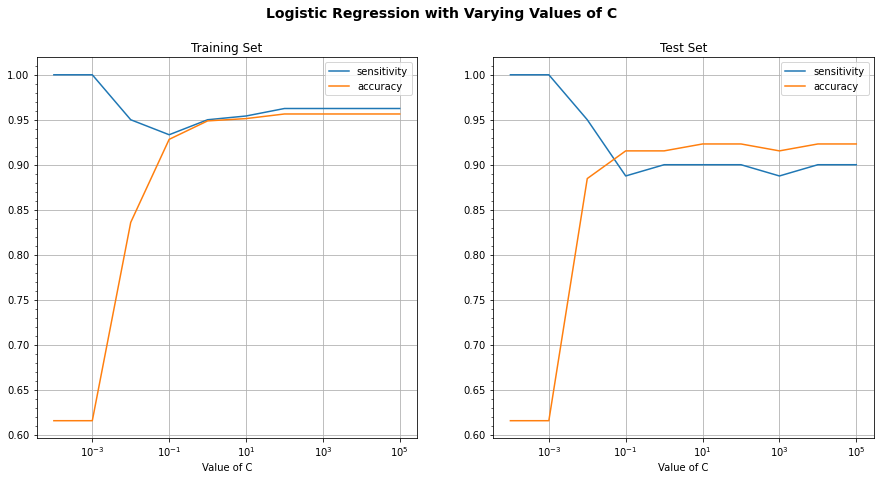

In [10]:
(fig, axes) = plot_metrics(x = logreg_c_array, y_array = [logreg_c_train_metrics, logreg_c_test_metrics],
             titles = ["Training Set", "Test Set"],
             x_label = "Value of C", figsize=(15,7), xscale='log', ticks={'y_minor': 0.01})
fig.suptitle("Logistic Regression with Varying Values of C", size=14, weight='semibold')
print()

With strong regularization (C = 0.0001), we achieve a sensitivity of 100% and an accuracy of about 61.5%. This is because the model has learned to classify all observations as positive. (In other words, there are no false negatives because the model is accurate only for the truly positive observations, which make up about 61.5% of the dataset.)

For low values of C, sensitivity decreases but accuracy increases. Around C = 10, both rates level off and remain mostly stable. This suggests that weak regularization leads to better performance of logistic regression models on this binary classification task.

Next, we decided to perform another experiment to examine whether PCA could improve the performance of our logistic regression model. As before, we used PCA with c components where c ranged from 1 to 16. We ran this new experiment with two different degrees of regularization — once with C = 0.01 and once with C = 10 — to see if our observation about performance decreasing as regularization increased still held true once PCA was added into the mix.

In [11]:
# num_trials is number of trials to run for each component (the average results of these trials will be used)
def logreg_with_pca_experiment(X, y, C, random_state=const_random_state):
    test_metrics = [] # result of trial with M components is stored in index M-1
    train_metrics = [] # result of trial with M components is stored in index M-1
    for M in components_arange(X):
        X_pca = PCA(n_components=M).fit_transform(X)
        X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, stratify=y, random_state=random_state)
        model = LogisticRegression(C=C, max_iter=1000000000).fit(X_train_pca, y_train)
        test_metrics.append(get_metrics(model, X_test_pca, y_test))
        train_metrics.append(get_metrics(model, X_train_pca, y_train))
    return (np.array(test_metrics), np.array(train_metrics))

logreg_pca_c_1 = 0.01
logreg_pca_c_2 = 10
(logreg_pca_test_1_metrics, logreg_pca_train_1_metrics) = logreg_with_pca_experiment(X, y, logreg_pca_c_1)
(logreg_pca_test_2_metrics, logreg_pca_train_2_metrics) = logreg_with_pca_experiment(X, y, logreg_pca_c_2)

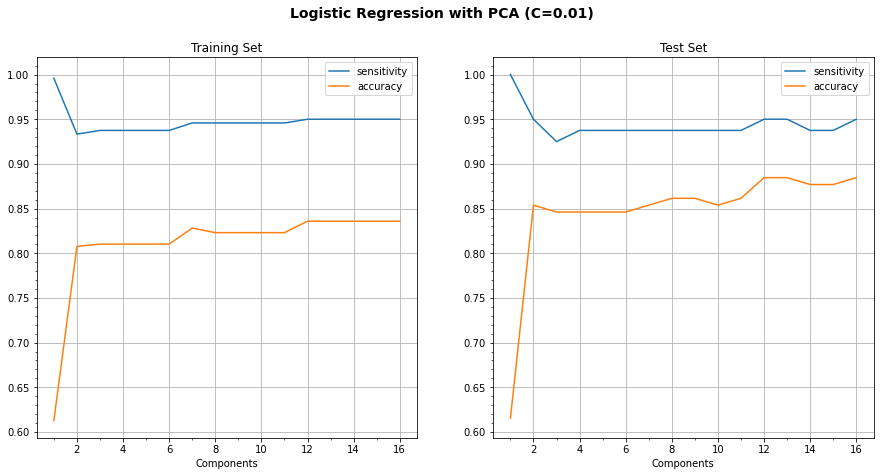

In [12]:
(fig, axes) = plot_metrics(x = components_arange(X), y_array = (logreg_pca_train_1_metrics, logreg_pca_test_1_metrics),
             titles = ["Training Set", "Test Set"],
             x_label = "Components",
             ticks = { 'x_minor': 1, 'y_major': 0.05, 'y_minor': 0.01 },
             separate_plots=False, figsize=(15,7))
fig.suptitle("Logistic Regression with PCA (C=" + str(logreg_pca_c_1) + ")", size=14, weight='semibold')
print()

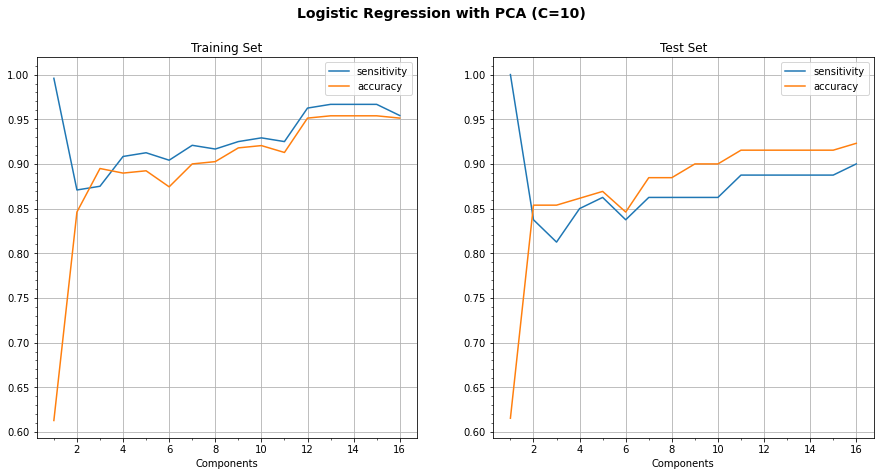

In [13]:
(fig, axes) = plot_metrics(x = components_arange(X), y_array = (logreg_pca_train_2_metrics, logreg_pca_test_2_metrics),
             titles = ["Training Set", "Test Set"],
             x_label = "Components",
             ticks = { 'x_minor': 1, 'y_major': 0.05, 'y_minor': 0.01 },
             separate_plots=False, figsize=(15,7))
fig.suptitle("Logistic Regression with PCA (C=" + str(logreg_pca_c_2) + ")", size=14, weight='semibold')
print()

Comparing the graphs with C = 0.01 and C = 10, we confirmed that the model achieves better performance with weaker regularization (larger values of C), even when factoring PCA into the equation.

With both values of C, when using PCA with a single component, we see the same problem of all observations being classified as positive that occurred in the previous experiment for C = 0.0001. However, this problem resolves itself when using PCA with two or more components. The performance of the model generally increases as the number of components increases, suggesting that PCA does not improve the base performance of logistic regression models for this binary classification task.

### Support Vector Machines

Next, we examined the performance of support vector machines (SVM) on our binary classification task. As with logistic regression, we began by examining how variation in the values of the hyperparameter C affects the model's performance. As the hyperparameter C increases, the size of the margin and the strength of the regularization decrease. The values of C used in the experiment ranged over powers of 10 from 10<sup>-4</sup> to 10<sup>2</sup>.

In [14]:
def svm_c_experiment(X, y, C_array, random_state=const_random_state):
    test_metrics = []
    train_metrics = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
    for C in C_array:
        model = LinearSVC(C=C, max_iter=1000000000).fit(X_train, y_train)
        test_metrics.append(get_metrics(model, X_test, y_test))
        train_metrics.append(get_metrics(model, X_train, y_train))
    return (np.array(test_metrics), np.array(train_metrics))

svm_c_array = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
(svm_c_test_metrics, svm_c_train_metrics) = svm_c_experiment(X, y, svm_c_array)

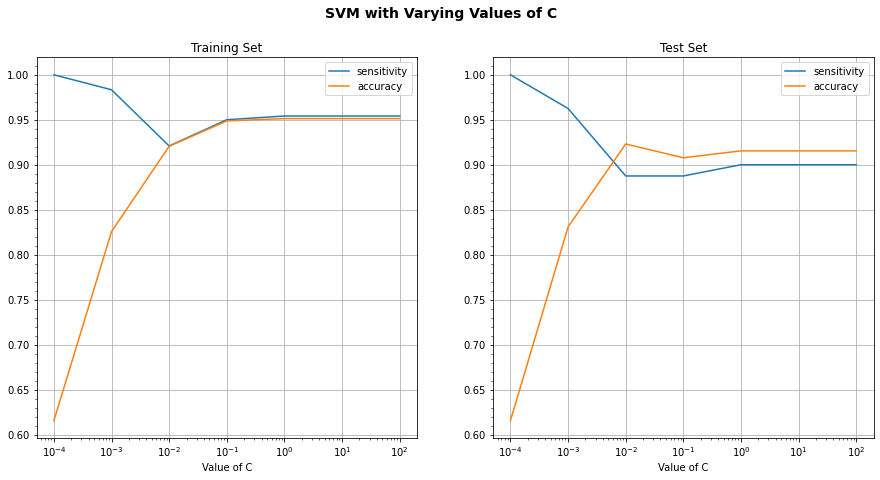

In [15]:
(fig, axes) = plot_metrics(x = svm_c_array, y_array = [svm_c_train_metrics, svm_c_test_metrics],
             titles = ["Training Set", "Test Set"],
             x_label = "Value of C", figsize=(15,7), xscale='log', ticks={'y_minor': 0.01})
fig.suptitle("SVM with Varying Values of C", size=14, weight='semibold')
print()

The results of this experiment are similar to the results of the analogous logistic regression experiment. Strong regularization (C = 0.0001) leads the model to classify all observations as positive. As C increases, the model performance increases as well; the accuracy and sensitivity level off and remain stable at about C = 1. This suggests that, as with logistic regression, weak regularization leads to better performance of SVM models on this binary classification task.

As with logistic regression, we performed a second experiment to examine whether PCA could improve the performance of the SVM model. We used PCA with c components, where c ranged from 1 to 16, and we held the strength of the regularization constant at C = 1 since our previous experiment indicated good performance with this value of C.

In [16]:
# num_trials is number of trials to run for each component (the average results of these trials will be used)
def svm_with_pca_experiment(X, y, C, random_state=const_random_state):
    test_metrics = [] # result of trial with M components is stored in index M-1
    train_metrics = [] # result of trial with M components is stored in index M-1
    for M in components_arange(X):
        X_pca = PCA(n_components=M).fit_transform(X)
        X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, stratify=y, random_state=random_state)
        model = LinearSVC(C=C, max_iter=1000000000).fit(X_train_pca, y_train)
        test_metrics.append(get_metrics(model, X_test_pca, y_test))
        train_metrics.append(get_metrics(model, X_train_pca, y_train))
    return (np.array(test_metrics), np.array(train_metrics))

svm_pca_c = 1
(svm_pca_test_metrics, svm_pca_train_metrics) = svm_with_pca_experiment(X, y, svm_pca_c)

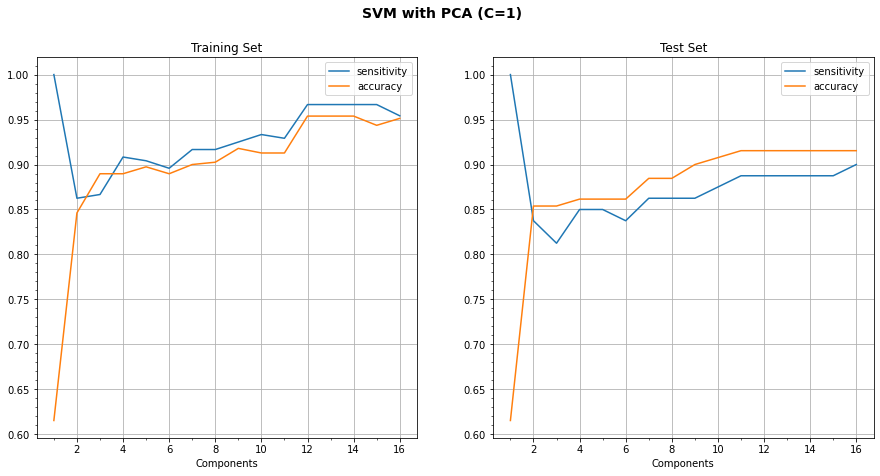

In [17]:
(fig, axes) = plot_metrics(x = components_arange(X), y_array = (svm_pca_train_metrics, svm_pca_test_metrics),
             titles = ["Training Set", "Test Set"],
             x_label = "Components",
             ticks = { 'x_minor': 1, 'y_major': 0.05, 'y_minor': 0.01 },
             separate_plots=False, figsize=(15,7))
fig.suptitle("SVM with PCA (C=" + str(svm_pca_c) + ")", size=14, weight='semibold')
print()

The results of this experiment are similar to the results of the analogous logistic regression with PCA experiment. The model performs worst with a single component, classifying all observations as positive, but improves in performance as the number of components increases. As a result, we conclude that PCA does not improve the base performance of SVM for this binary classification task.

### Multilayer Perceptrons

Finally, we performed an experiment to test the performance of multilayer perceptron (MLP) models. Fixing the number of hidden layers at 2, we varied the number of neurons in each layer to see how this would affect performance. For each number of neurons per hidden layer (10, 100, or 500), we tested the performance of MLP with each of the four activation functions provided by sklearn's implementation. These four activation functions are "identity" (a no-op function), "logistic" (the logistic sigmoid function), "tanh" (the hyperbolic tangent function), and "relu" (the rectified linear unit function). We used a constant random state to ensure that the results for each combination of hyperparameters could be meaningfully compared.

In [18]:
def mlp_with_activations(X, y, activations, hidden_layer_sizes, max_iter=5000, train_test_split_random_state=const_random_state, mlp_random_state=const_random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=train_test_split_random_state)
    test_metrics = []
    train_metrics = []
    for activation in activations:
        model = MLPClassifier(activation=activation, max_iter=5000, hidden_layer_sizes=hidden_layer_sizes, random_state=mlp_random_state).fit(X_train, y_train)
        test_metrics.append(get_metrics(model, X_test, y_test))
        train_metrics.append(get_metrics(model, X_train, y_train))
    return (np.array(test_metrics), np.array(train_metrics))

activations = ('identity', 'logistic', 'tanh', 'relu')
hidden_layer_sizes = [
    [10, 10],
    [100, 100],
    [500, 500],
]
all_mlp_act_sizes_test_metrics = []
all_mlp_act_sizes_train_metrics = []
for size in hidden_layer_sizes:
    (test_metrics, train_metrics) = mlp_with_activations(X, y, activations, size)
    all_mlp_act_sizes_test_metrics.append(test_metrics)
    all_mlp_act_sizes_train_metrics.append(train_metrics)

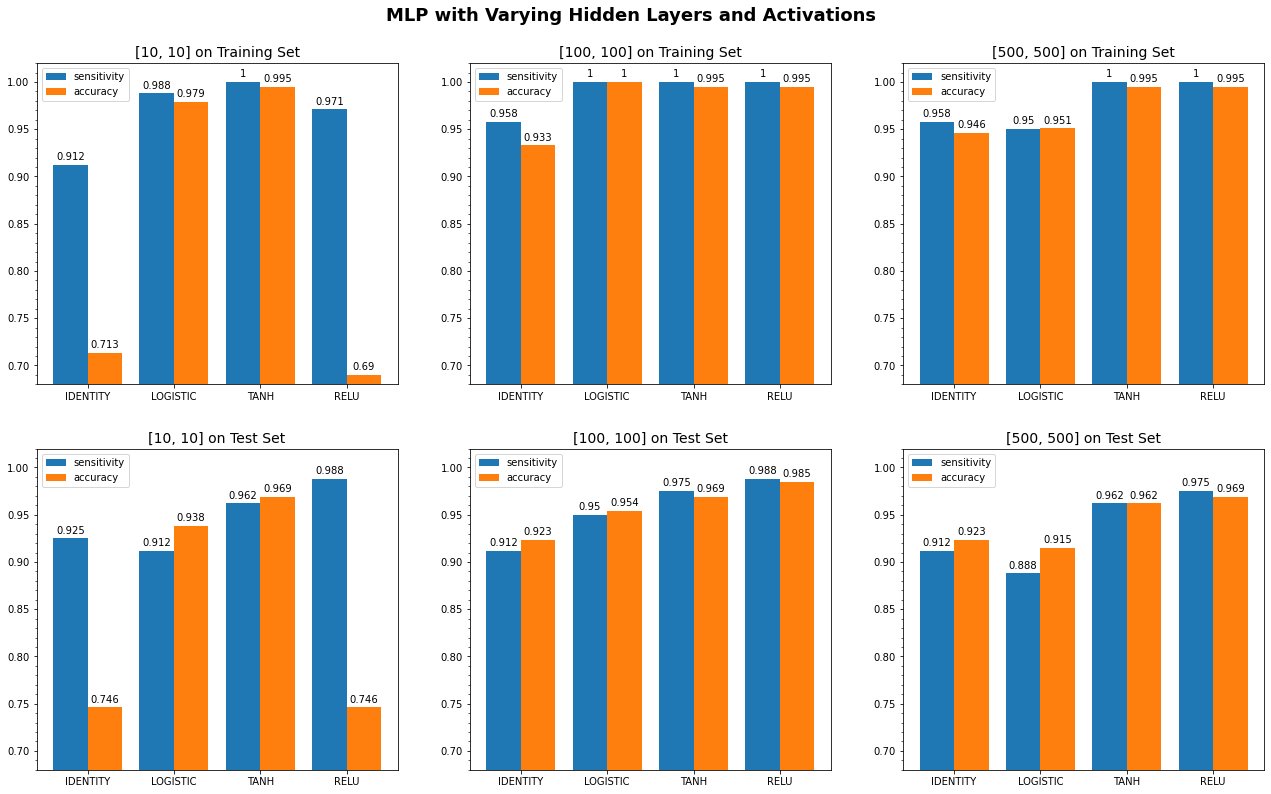

In [19]:
experiment_results = (
    [{ metric : np.round(metrics[:, index],3) for metric, index in metric_indices.items() } for metrics in all_mlp_act_sizes_train_metrics],
    [{ metric : np.round(metrics[:, index],3) for metric, index in metric_indices.items() } for metrics in all_mlp_act_sizes_test_metrics]
)
experiment_results_labels = ('Training Set', 'Test Set')

fig, axes = plt.subplots(sharey=True, figsize=((22,13)), nrows = len(experiment_results), ncols = len(hidden_layer_sizes))

x = np.arange(len(activations))
width = 0.4
fig.suptitle('MLP with Varying Hidden Layers and Activations', y=0.94, size=18, weight='semibold')
axes[0][0].yaxis.set_minor_locator(ticker.MultipleLocator(0.01)) # copied to all other axes since sharey is True
for i in range(len(experiment_results)):
    for j, data_dict in enumerate(experiment_results[i]):
        axis = axes[i][j]
        factor = 0
        for metric, rates in data_dict.items():
            rects = axis.bar(x + width*factor, rates, width, label=metric)
            axis.bar_label(rects, padding=3)
            factor+=1
        axis.set_xticks(x+width/2, np.char.upper(activations))
        axis.tick_params(left=True, labelleft=True)
        axis.set_ylim(0.68, 1.02)
        axis.set_title(str(hidden_layer_sizes[j]) + ' on ' + experiment_results_labels[i], size=14)
        axis.legend(loc='upper left')

We observed the worst performance with 10 neurons in each layer — especially with regards to accuracy — and the best performance with 100 neurons in each layer. This suggests that performance decreases if there are either too few or too many neurons in each layer.

Among the models with 100 neurons per hidden layer, the rectified linear unit function (ReLU) has the best performance of the four activation functions. But ReLU does not consistently achieve the best results; with 10 neurons per hidden layer, for example, ReLU has the second-worst performance on the test set.

The hyperbolic tangent activation function has the most consistently good performance across the different numbers of neurons per hidden layer. The identity and logistic activation functions seem to suffer most significantly from overfitting when comparing their results on the training set to their results on the test set.

### Model Comparison

Now that we have run experiments for each of these five machine learning techniques, we will conclude by comparing the best model for each technique. Since our goal is to maximize both accuracy and sensitivity, we will define the best model for each technique as the model that has the highest mean of accuracy and sensitivity.

In [20]:
best_model_metrics = {}
best_model_meta = {}

larger_mean = lambda a, b : True if b is None else np.mean(a) > np.mean(b)

# find best KNN model
best_mean = None
best_mean_meta = ""
# find best KNN model without PCA
for k, pair in zip(k_array, knn_test_metrics):
    if larger_mean(pair, best_mean):
            best_mean = pair
            best_mean_meta = "The best KNN model has k = " + str(k) + " and does not use PCA"
# compare to best KNN model with PCA
for k, metrics in zip(odd_k_array, knn_neighbors_pca_test_metrics):
    for component, pair in zip(components, metrics):
        if larger_mean(pair, best_mean):
            best_mean = pair
            best_mean_meta = "The best KNN model has k = " + str(k) + " and uses PCA with " + str(component) + " components"
best_model_metrics['KNN'] = best_mean
best_model_meta['KNN'] = best_mean_meta

# find best logistic regression model

# find best GMM model
best_mean = None
best_mean_meta = ""
for trial, metrics in enumerate(all_gauss_pca_test_metrics):
    for component, pair in zip(components, metrics):
        if larger_mean(pair, best_mean):
            best_mean = pair
            best_mean_meta = "The best GMM model uses PCA with " + str(component) + " components and was trained on trial " + str(trial+1)
best_model_metrics['GMM'] = best_mean
best_model_meta['GMM'] = best_mean_meta

# find best LOGREG model
best_mean = None
best_mean_meta = ""
# find best LOGREG model without PCA
for C, pair in zip(logreg_c_array, logreg_c_test_metrics):
    if larger_mean(pair, best_mean):
        best_mean = pair
        best_mean_meta = "The best LOGREG model has C = " + str(C) + " and does not use PCA"
# compare to best LOGREG model with PCA and first C value
for component, pair in zip(components, logreg_pca_test_1_metrics):
    if larger_mean(pair, best_mean):
        best_mean = pair
        best_mean_meta = "The best LOGREG model has C = " + str(logreg_pca_c_1) + " and uses PCA with " + str(component) + " components"
# compare to best LOGREG model with PCA and second C value
for component, pair in zip(components, logreg_pca_test_2_metrics):
    if larger_mean(pair, best_mean):
        best_mean = pair
        best_mean_meta = "The best LOGREG model has C = " + str(logreg_pca_c_2) + " and uses PCA with " + str(component) + " components"

best_model_metrics['LOGREG'] = best_mean
best_model_meta['LOGREG'] = best_mean_meta

# find best SVM model
best_mean = None
best_mean_meta = ""
# find best SVM model without PCA
for C, pair in zip(svm_c_array, svm_c_test_metrics):
    if larger_mean(pair, best_mean):
        best_mean = pair
        best_mean_meta = "The best SVM model has C = " + str(C) + " and does not use PCA"
# compare to best SVM model with PCA
for component, pair in zip(components, svm_pca_test_metrics):
    if larger_mean(pair, best_mean):
        best_mean = pair
        best_mean_meta = "The best SVM model has C = " + str(svm_pca_c) + " and uses PCA with " + str(component) + " components"

best_model_metrics['SVM'] = best_mean
best_model_meta['SVM'] = best_mean_meta

# find best MLP model
best_mean = None
best_mean_meta = ""
for size, metrics in zip(hidden_layer_sizes, all_mlp_act_sizes_test_metrics):
    for activation, pair in zip(activations, metrics):
        if larger_mean(pair, best_mean):
            best_mean = pair
            best_mean_meta = "The best MLP model has random state = " + str(const_random_state) + ", activation = " + activation.upper() + ", and hidden layer sizes = " + str(size)
best_model_metrics['MLP'] = best_mean
best_model_meta['MLP'] = best_mean_meta


* The best KNN model has k = 1 and uses PCA with 9 components.
* The best GMM model uses PCA with 11 components and was trained on trial 2.
* The best LOGREG model has C = 0.01 and does not use PCA.
* The best SVM model has C = 1 and does not use PCA.
* The best MLP model has random state = 42, activation = RELU, and hidden layer sizes = [100, 100].



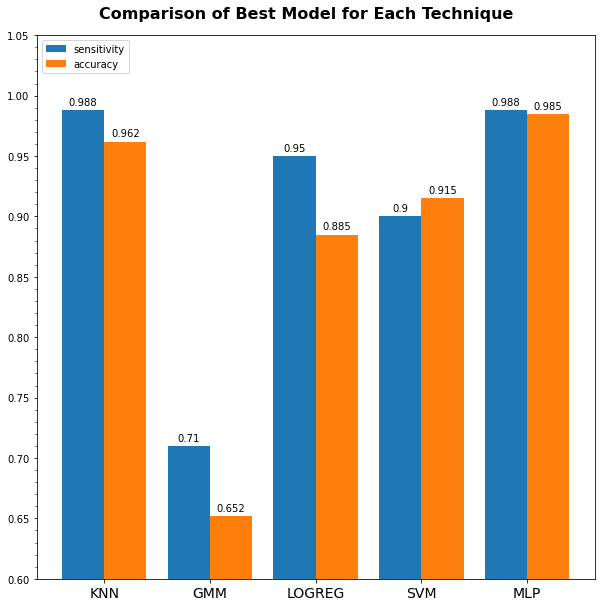

In [21]:
model_names = best_model_metrics.keys()
best_metrics = {
    "sensitivity": [pair[metric_indices["sensitivity"]] for pair in best_model_metrics.values()],
    "accuracy": [pair[metric_indices["accuracy"]] for pair in best_model_metrics.values()],
}

fig, axis = plt.subplots(figsize=(10,10))
x = np.arange(len(model_names))
factor = 0
width = 0.4
fig.suptitle('Comparison of Best Model for Each Technique', y=0.92, size=16, weight='semibold')
for metric, rates in best_metrics.items():
    rects = axis.bar(x + width*factor, np.round(rates, 3), width, label=metric)
    axis.bar_label(rects, padding=3)
    factor+=1
axis.set_xticks(x+width/2, model_names, size=14)
axis.legend(loc='upper left')
axis.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
axis.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
axis.set_ylim(0.6, 1.05)

print()
for meta in best_model_meta.values():
    print("* " + meta + ".")
print()

As the graph above shows, GMM achieves the worst performance of the five techniques. Logistic regression and SVM are next best, with logistic regression achieving higher sensitivity and SVM achieving higher accuracy. KNN and MLP achieve the best performance, with MLP tying with KNN on sensitivity but outperforming KNN in terms of accuracy. Based on these results, we recommend either the KNN model or the MLP model as the best choice of these five for physicians to use as a machine learning aid for screening patients for diabetes.

We realize that there may be shortcomings or issues with using the highest mean of sensitivity and accuracy as our standard to determine which model is the best model. If we had more time, we would have liked to explore other ways of comparing our experimental results to determine which model performed best to see if the mean score method we are currently using works well or if another method of comparison would be more informative.

### Conclusions Applied to Healthcare/Medical Context

The results obtained from these experiments using various machine learning techniques better inform us on how we can use the different machine learning techniques we tested to find and train effective models for assisting a physician in analyzing and interpreting data to inform proper proper diagnosis and effective treatment to a patient with diabetes. 

Some specific conclusions that we can draw as a result of our experiments are as follows: 
1. Based on the comparisons we made using the best machine learning techniques, it seems probable that training our model with neural nets, specifically with multi-layer perceptrons (with random state, activation function, and number of hidden layers as noted above the histogram displaying the comparisons), would be a viable option considering this dataset. This machine learning technique allows the model to achieve the most accuracy and sensitivity; this would help physicians more likely diagnose patients correctly as well as decrease the risk of patients who have diabetes being misclassified as negative for diabetes, and, thus, not receiving treatment or a second-look by a physician. Additionally, the scores for accuracy and sensitivity are close together, indicating that with this technique, the model is likely achieving correct patient diagnosis and minmizing the number of patients who have diabetes but are not treated because they are classfied as negative for diabetes. 



2. KNN also seems to be a viable option for training our model given that PCA is used with a number of components that lends itself to producing good accuracy and sensitivity results (as with 9 components). Based on our experiments, it also seems that ensuring that the model only uses 1 neighbor (in other words, the data point itself), to achieve the best results is important for best performance. Considering number of neighbors and the number of components when incorporating KNN with PCA is very crucial in making sure that the model performs well, especially if the model were to be used to assist in patient diagnosis. As with MLP, KNN with PCA tends to produce high accuracy and sensitivity results. Both accuracy and sensitivity score similarly. If the physican finds it of greater importance to decrease the number of false negatives over accurate diagnoses, KNN with PCA would be as good an option as MLP; it would be at the physican's discretion to determine the trade-offs for doing so. 



3. The SVM model and logistic regression models (both with corresponding C values 1 and 0.01, respectively, and without PCA) may not be the best options compared to the other best model results shown above, but still serve as good options for a physician to use. Both score well for accuracy and sensitivity, ensuring correct diagnosis and minmization of false negatives most of the time. The best logistic regression model scores better with sensitivity than accuracy; contrastingly, the best SVM model scores better with accuracy than sensitivity. If considering these models, a physican should determine whether they would find a situation in which they find it more important for either accuracy or sensitivity scores to be significantly better. Since the best MLP model and the best KNN model seem to perform better and with less variance between accuracy and sensitivity scores, our suggestion would be for one of those models to be used instead with the corresponding parameters that would ensure best results. 



4. Considering the inconsistent performance and low sensitivity and accuracy scores resulting from GMM, we would advise physicans to not use this technique in training their machine learning models on this dataset. Based on its poor performance, it runs the risk of misclassifying patients as positive or negative for diabetes, which could be detrimentally life threatening to patients and could also put a physican in jeopardy for incorrectly treating or diagnosing a patient if there are adverse effects.